In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle, os
import pandas as pd
from tqdm import tqdm 

## Load Important Function

In [2]:
class Data:
    def __init__(self, array_list):
        self.array_list = array_list

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.array_list, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            array_list = pickle.load(f)
        return cls(array_list)

In [3]:
def omega2cistrans(omega):
    """Converts a sequence of float omega angles (in degrees) to an array of ints: 0 cis and 1 trans."""
    
    shifted_omega = (omega + 90.0) % 360.0 - 90.0 # shift into (-90, 270) range to avoid periodic boundaries
    
    cistrans = np.where(shifted_omega > 90.0, 1, 0).astype(int)
    return cistrans

In [4]:
def state_to_index_vectorized(all_state):
    """
    Converts a (N, M, 4) array of states into (N, M) indices in [0..31].
    
    Assumes:
      - The first three entries in the state are binary bits (0 or 1).
      - The last entry is an integer in [0..3].
      - If any of the four entries is NaN, the output is NaN for that row.
    
    Parameters
    ----------
    all_state : array-like
        An array of shape (N, M, 4).
    
    Returns
    -------
    indexed_states : ndarray
        A float array of shape (N, M). Valid rows are in the range [0..31].
        Rows with NaNs in the input remain NaN.
    """
    # Convert to numpy array (float allows NaN)
    all_state_array = np.array(all_state, dtype=float)

    # Validate shape: we want (N, M, 4)
    if all_state_array.ndim != 3 or all_state_array.shape[-1] != 4:
        raise ValueError(f"Unexpected shape: {all_state_array.shape}, expected (N, M, 4).")
    
    # Create mask for rows that have ANY NaN
    nan_mask = np.isnan(all_state_array).any(axis=-1)  # shape: (N, M)

    # Prepare an output array filled with NaNs
    indexed_states = np.full(all_state_array.shape[:-1], np.nan, dtype=float)  # shape: (N, M)

    # For valid rows (no NaNs), compute the index
    valid_mask = ~nan_mask

    # Weights for [a, b, c, x] => 16a + 8b + 4c + x
    # This yields a unique integer in [0..31].
    weights = np.array([16, 8, 4, 1], dtype=float)

    # Extract the valid data (2D: some number of rows by 4 columns)
    valid_data = all_state_array[valid_mask]  # shape: (?, 4)

    # Dot product for each row => scalar
    results = valid_data @ weights  # shape: (?)

    # Place results in the output
    indexed_states[valid_mask] = results

    return indexed_states



In [5]:
def index_to_state(index):
    """
    Converts an index (0-31) into a (4,) array where the first three
    entries are binary bits (0 or 1) and the last entry is in [0..3].

    The logic is:
      - The last entry is index % 4.
      - The first 3 bits come from index // 4, in [0..7].
    """
    if not (0 <= index < 32):
        raise ValueError(f"Index out of range: {index}. Expected 0-31.")

    # Last element: in [0..3]
    last_part = index % 4

    # The 3-bit portion is the integer in [0..7]
    binary_index = index // 4  # in [0..7]

    # Convert that binary_index into a 3-bit binary string, e.g. '011'
    binary_str = format(binary_index, '03b')

    # Create an array of the three bits
    bits = np.array([int(bit) for bit in binary_str], dtype=int)

    # Combine [first 3 bits, last_part]
    state = np.concatenate([bits, [last_part]])
    
    return state

In [6]:
import numpy as np
from tqdm import tqdm

def calculate_conform_p(trajs, conform_num):
    """
    Calculates the cumulative average population of each conformational state over time,
    excluding NaN values in the trajectory.

    Parameters
    ----------
    trajs : np.ndarray
        A 1D array of shape (timesteps,), where each value is either an integer in 
        [0, conform_num-1] or NaN (for missing data).

    conform_num : int
        The total number of conformational states.

    Returns
    -------
    conform_population : np.ndarray
        Array of shape (conform_num, valid_timesteps) — cumulative average population per conformation.
    """
    trajs = np.asarray(trajs)

    # Only keep valid time steps (non-NaN)
    valid_mask = ~np.isnan(trajs)
    trajs_clean = trajs[valid_mask]
    n_time = trajs_clean.shape[0]

    conform_population = np.zeros((conform_num, n_time), dtype=float)

    for conform_state in range(conform_num):
        match_mask = (trajs_clean == conform_state).astype(float)  # shape: (n_time,)

        cumulative_counts = np.cumsum(match_mask)  # shape: (n_time,)
        time_steps = np.arange(1, n_time + 1)      # shape: (n_time,)

        cumulative_proportions = cumulative_counts / time_steps  # shape: (n_time,)
        conform_population[conform_state] = cumulative_proportions

    #print('Conform population shape:', conform_population.shape)

    return conform_population


## Prepare the Data and the log (indicating of the data state)

In [7]:
save_dir = 'omega_data'
all_omega = Data.load(f"{save_dir}/all_omega.pkl").array_list  # This is an (85, x, 3) array
# Convert each array in the list to float
all_omega = [arr.astype(float) for arr in all_omega]

# Apply omega2cistrans() to each array in all_omega
all_cistrans = [omega2cistrans(arr) for arr in all_omega]

# Print shape of the first converted array for verification
print(f"First array shape after conversion: {all_cistrans[0].shape}")

First array shape after conversion: (206002, 3)


In [8]:
# Find the minimum x-dimension across all arrays
min_x = min(arr.shape[0] for arr in all_cistrans)

print(f"Shortest x in all_cistrans: {min_x}")

Shortest x in all_cistrans: 171002


In [9]:
# Define paths
traj_path = '../PROJ12462traj'
log_path = '../log'

all_state = []

# Iterate over RUN and CLONE indices
for r in range(2, 3):  # Only r=2 for now
    for c in range(100):  # Iterate over c=0 to c=99
        csv_log = f"{log_path}/RUN{r}_CLONE{c}_log.csv"
        input_xtc_file = f"{traj_path}/r{r}c{c}_inte.xtc"

        # Corrected condition: Check if either file is missing
        if not os.path.exists(csv_log) or not os.path.exists(input_xtc_file):
            print(f"Missing file(s): {input_xtc_file if not os.path.exists(input_xtc_file) else ''}")
            print(f"Missing log file(s): {csv_log if not os.path.exists(csv_log) else ''}")
            continue

        # Load log and convert states
        df_log = pd.read_csv(csv_log, header=0)
        log = df_log.iloc[:, 0].values  # Convert to NumPy array
        all_state.append(log)

all_state

[array([0, 2, 1, ..., 1, 3, 2]),
 array([0, 1, 3, ..., 3, 3, 0]),
 array([0, 1, 3, ..., 3, 3, 1]),
 array([0, 2, 0, ..., 3, 3, 3]),
 array([0, 2, 1, ..., 3, 3, 3]),
 array([0, 2, 1, ..., 0, 0, 0]),
 array([0, 2, 1, ..., 1, 3, 3]),
 array([0, 3, 2, ..., 3, 3, 2]),
 array([0, 1, 3, ..., 2, 0, 0]),
 array([0, 3, 0, ..., 3, 2, 3]),
 array([0, 2, 1, ..., 1, 0, 0]),
 array([0, 2, 0, ..., 1, 0, 1]),
 array([0, 2, 3, ..., 0, 0, 2]),
 array([0, 2, 2, ..., 2, 0, 0]),
 array([0, 3, 2, ..., 2, 2, 3]),
 array([0, 1, 3, ..., 2, 3, 1]),
 array([0, 2, 3, ..., 1, 0, 1]),
 array([0, 2, 1, ..., 2, 0, 2]),
 array([0, 2, 0, ..., 2, 1, 1]),
 array([0, 1, 3, ..., 2, 1, 0]),
 array([0, 1, 3, ..., 0, 0, 0]),
 array([0, 2, 1, ..., 1, 3, 3]),
 array([0, 3, 0, ..., 1, 3, 0]),
 array([0, 1, 1, ..., 0, 1, 1]),
 array([0, 1, 0, ..., 3, 3, 3]),
 array([0, 1, 1, ..., 1, 0, 0]),
 array([0, 2, 3, ..., 1, 3, 2]),
 array([0, 2, 0, ..., 0, 1, 0]),
 array([0, 2, 3, ..., 3, 3, 3]),
 array([0, 1, 1, ..., 0, 2, 1]),
 array([0,

In [10]:
import numpy as np

unique_states = np.unique(all_state[9])
print(unique_states)


[0 1 2 3]


## Create a new data with 85, x, 4 (binary cis/trans state + lambda state)

In [11]:
# Assuming all_cistrans and all_state are lists of numpy arrays
new_all = []

for i in range(len(all_cistrans)):  # Loop over 85 trajectories
    x_len = all_cistrans[i].shape[0]  # Get the x dimension from all_cistrans

    # Trim all_state[i] to match the first x_len frames
    state_trimmed = all_state[i][:x_len]  # Ensure same length along x

    # Reshape state to (x, 1) if necessary
    state_trimmed = state_trimmed.reshape(-1, 1)  # Ensure shape (x, 1)

    # Concatenate along the last axis to get (x, 4)
    combined = np.concatenate((all_cistrans[i], state_trimmed), axis=1)

    # Append to new list
    new_all.append(combined)

new_all[4]

array([[1, 1, 1, 0],
       [1, 0, 0, 2],
       [1, 0, 1, 1],
       ...,
       [0, 1, 0, 2],
       [0, 1, 0, 2],
       [0, 1, 0, 0]])

## Make a whole np traj.shape (85, 37002, 4) with nan, and convert the [1111] into individual 32 state

In [12]:
ntraj = len(new_all)
print(ntraj)

# Find the longest traj
maxlength = max( [ len(new_all[i]) for i in range(ntraj) ])
print('maxlength', maxlength)

# Make an array to store all the trajectories
traj = np.nan * np.ones( (ntraj, maxlength, 4) )

for i in range(ntraj):
    n = len(new_all[i])
    traj[i, 0:n, :] = new_all[i]

traj

100
maxlength 318010


array([[[ 1.,  1.,  1.,  0.],
        [ 0.,  1.,  1.,  2.],
        [ 0.,  1.,  1.,  1.],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[ 1.,  1.,  1.,  0.],
        [ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  3.],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[ 1.,  1.,  1.,  0.],
        [ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  3.],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       ...,

       [[ 1.,  1.,  1.,  0.],
        [ 0.,  1.,  1.,  0.],
        [ 0.,  1.,  1.,  2.],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[ 1.,  1.,  1.,  0.],
        [ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  3.],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[ 1.

In [13]:
print('traj.shape', traj.shape)

traj_indexed = state_to_index_vectorized(traj)
print('traj_indexed.shape', traj_indexed.shape)
traj_indexed

traj.shape (100, 318010, 4)
traj_indexed.shape (100, 318010)


array([[28., 14., 13., ..., nan, nan, nan],
       [28., 29., 31., ..., nan, nan, nan],
       [28., 29., 31., ..., nan, nan, nan],
       ...,
       [28., 12., 14., ..., nan, nan, nan],
       [28., 29., 31., ..., nan, nan, nan],
       [28., 28., 31., ..., nan, nan, nan]])

## Calculating the cistrans population overtime

(318010,)


(0.0, 0.125)

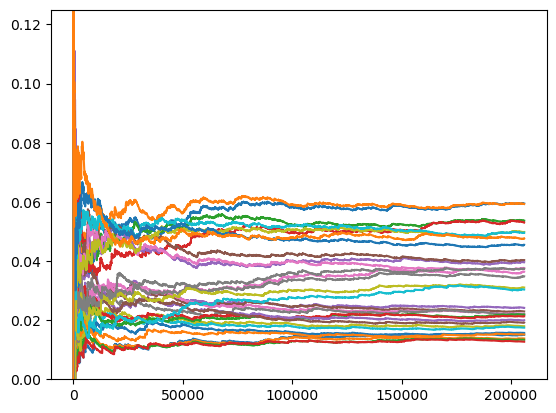

In [14]:
conform_num = 32

conform_population = calculate_conform_p(traj_indexed[0], conform_num)
print(traj_indexed[0].shape)
plt.plot(conform_population.T)  # Transpose: shape (37002, 32)
plt.ylim(0, 0.125)

In [15]:
ntraj = traj_indexed.shape[0]
conform_num = 32

all_conform_populations = []
for i in range(ntraj):
    traj = traj_indexed[i]
    conform_p = calculate_conform_p(traj, conform_num)
    all_conform_populations.append(conform_p)


# Find the longest trajectory (in terms of time steps)
maxlength = max([all_conform_populations[i].shape[1] for i in range(ntraj)])
print('maxlength', maxlength)

# Make an array to store all the conformational populations with padding
all_conform_p = np.full((ntraj, conform_num, maxlength), np.nan)

for i in range(ntraj):
    conform_p = all_conform_populations[i]
    time_len = conform_p.shape[1]
    all_conform_p[i, :, :time_len] = conform_p
print('all_conform_p.shape', all_conform_p.shape)



all_thermal_conform_mean = np.nanmean(all_conform_p, axis=0)
all_thermal_conform_std = np.nanstd(all_conform_p, axis=0)
all_thermal_conform_mean.shape

maxlength 318010
all_conform_p.shape (100, 32, 318010)


(32, 318010)

In [16]:
conform_num = 8
thermal_num = 4
state_0_Ind = np.arange(0, 32, 4)
time_len = all_thermal_conform_mean.shape[1]  # assuming shape = (thermal_num * conform_num, time)
ntraj = all_conform_p.shape[0]

# Preallocate arrays
reshaped_mean = np.full((thermal_num, conform_num, time_len), np.nan)
reshaped_std = np.full((thermal_num, conform_num, time_len), np.nan)
reshaped_all_comform = np.full((ntraj, thermal_num, conform_num, time_len), np.nan)


for thermal in range(thermal_num):
    reshaped_mean[thermal] = all_thermal_conform_mean[state_0_Ind + thermal]
    reshaped_std[thermal] = all_thermal_conform_std[state_0_Ind + thermal]

    # Renormalization
    reshaped_mean[thermal] /= np.sum(reshaped_mean[thermal], axis=0)


for traj in range(ntraj):
    for thermal in range(thermal_num):
        reshaped_all_comform[traj][thermal] = all_conform_p[traj][state_0_Ind + thermal]
        reshaped_all_comform[traj][thermal] /= np.sum(reshaped_all_comform[traj][thermal], axis=0)

# Normalize over conformers at each time point per thermal group



reshaped_all_comform.shape

/var/folders/d8/y2dvs1ln1gjcwccrkvtffr240000gn/T/ipykernel_1822/164090747.py:18: RuntimeWarning: invalid value encountered in divide
  reshaped_mean[thermal] /= np.sum(reshaped_mean[thermal], axis=0)
/var/folders/d8/y2dvs1ln1gjcwccrkvtffr240000gn/T/ipykernel_1822/164090747.py:24: RuntimeWarning: invalid value encountered in divide
  reshaped_all_comform[traj][thermal] /= np.sum(reshaped_all_comform[traj][thermal], axis=0)


(100, 4, 8, 318010)

## Plot for each thermal

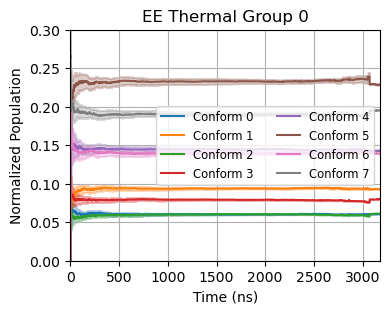

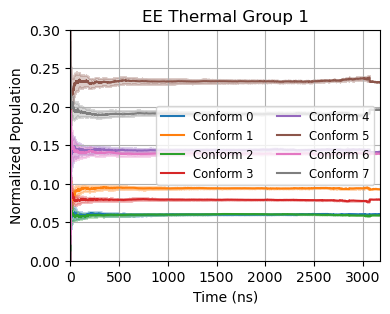

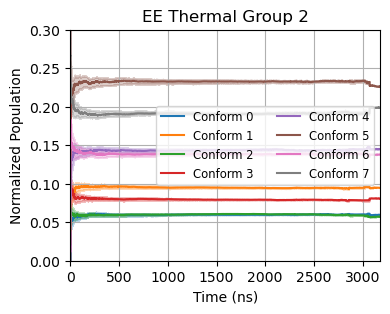

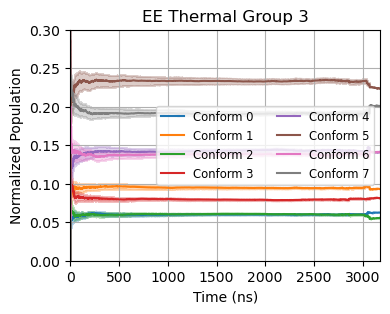

In [17]:
dt_in_ns = 0.01  # 10 ps = 0.01 ns

conform_num = 8
thermal_num = 4

for thermal in range(thermal_num):
    time = np.arange(reshaped_mean.shape[2])
    time_ns = time * dt_in_ns  # Convert to nanoseconds

    plt.figure(figsize=(4, 3))

    for conform in range(conform_num):
        mean = reshaped_mean[thermal, conform, :]
        rmsd = reshaped_std[thermal, conform, :]

        # Plot and capture the line object to get the color
        line, = plt.plot(time_ns, mean, label=f'Conform {conform}')
        plt.fill_between(time_ns, mean - rmsd, mean + rmsd, alpha=0.3, color=line.get_color())
        
    plt.ylim(0, 0.3)
    plt.xlim(time_ns[0], time_ns[-1])  # Optional but precise
    plt.xlabel("Time (ns)")
    plt.ylabel("Normalized Population")
    plt.title(f"EE Thermal Group {thermal}")
    plt.legend(loc='right',fontsize='small', ncol=2)
    plt.grid(True)
    #plt.tight_layout()
    plt.show()
    plt.close()


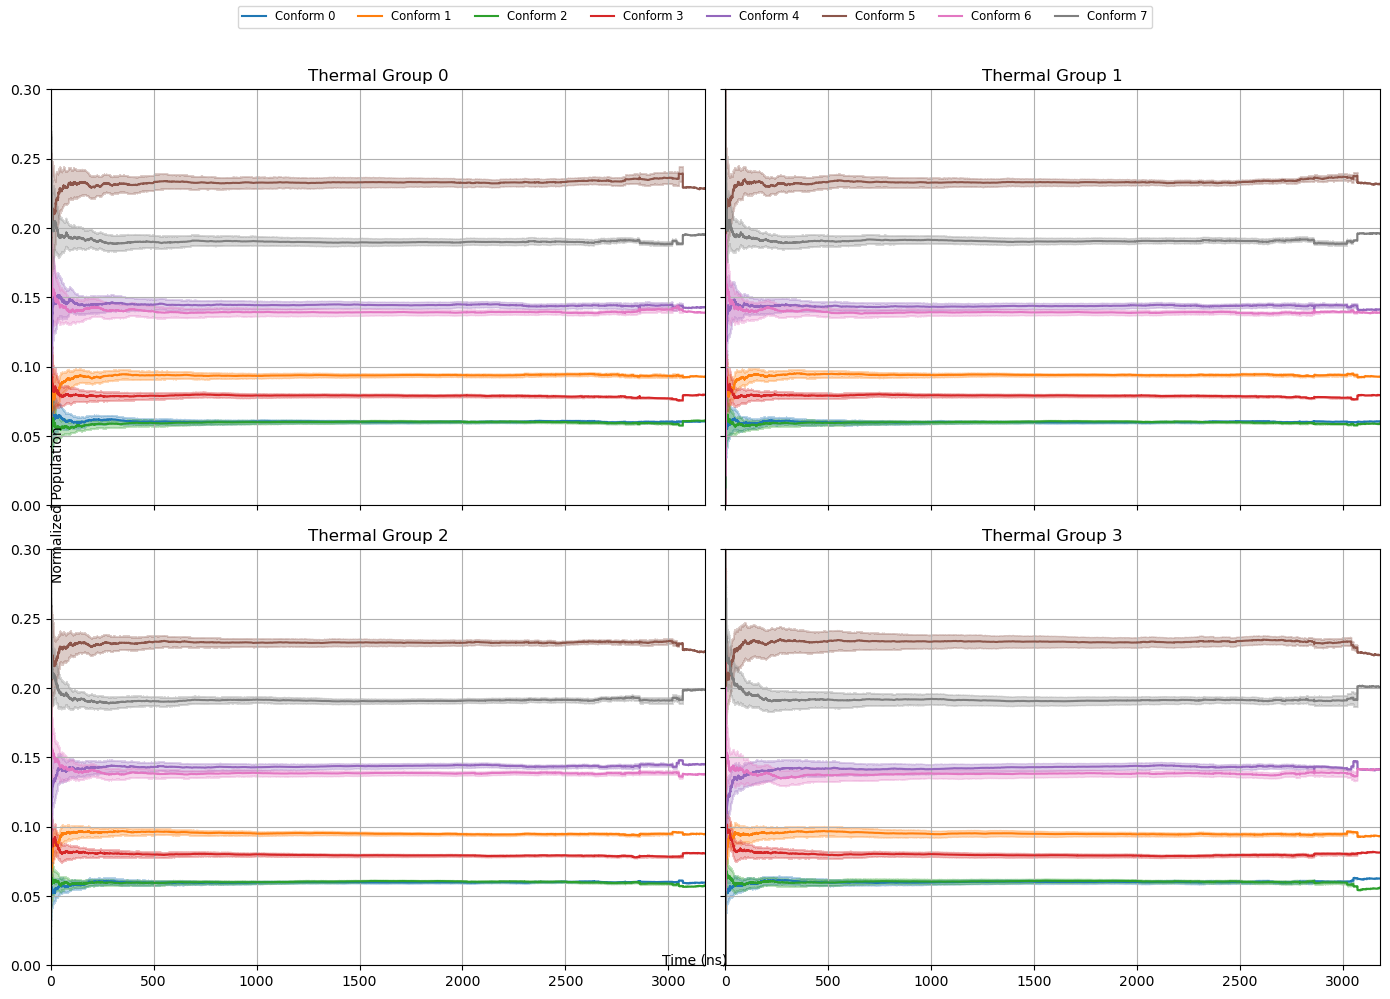

In [18]:
dt_in_ns = 0.01  # 10 ps = 0.01 ns
conform_num = 8
thermal_num = 4

# Set up 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)

time = np.arange(reshaped_mean.shape[2])
time_ns = time * dt_in_ns

for thermal in range(thermal_num):
    row = thermal // 2
    col = thermal % 2
    ax = axes[row, col]

    for conform in range(conform_num):
        mean = reshaped_mean[thermal, conform, :]
        rmsd = reshaped_std[thermal, conform, :]
        line, = ax.plot(time_ns, mean, label=f'Conform {conform}')
        ax.fill_between(time_ns, mean - rmsd, mean + rmsd, alpha=0.3, color=line.get_color())

    ax.set_ylim(0, 0.3)
    ax.set_xlim(time_ns[0], time_ns[-1])
    ax.set_title(f"Thermal Group {thermal}")
    ax.grid(True)

# Set shared labels
fig.text(0.5, 0.04, 'Time (ns)', ha='center')
fig.text(0.04, 0.5, 'Normalized Population', va='center', rotation='vertical')

# Add legend outside the plot
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=8, fontsize='small')

fig.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the legend
plt.show()


In [19]:
reshaped_mean.shape
reshaped_std.shape

(4, 8, 318010)

In [20]:
os.makedirs('population_data', exist_ok=True)
population_result = [reshaped_mean, reshaped_std]
data_instance = Data(population_result)
data_instance.save("population_data/population_8_conform.pkl")

In [21]:
population_result_reduced = [reshaped_mean[:, :, ::100], reshaped_std[:, :, ::100]]
data_instance = Data(population_result_reduced)
data_instance.save("population_data/population_8_conform_reduced.pkl")

## Individual Error over time

In [22]:
## Load in the refer data 

df_stationary_p = pd.read_csv("autocoorel_data/trans_population_at_lagtime_8conforms.csv")
#print(df_stationary_p)

    
# Pivot the DataFrame to reshape it
pivot_mean = df_stationary_p.pivot(index='thermo_state', columns='conform_state', values='mean')
pivot_std = df_stationary_p.pivot(index='thermo_state', columns='conform_state', values='std')

# Convert to NumPy arrays
refer_array = pivot_mean.to_numpy()  # shape (6, 3) state, residues 
refer_err_array = pivot_std.to_numpy()  # shape (6, 3)
refer_array.shape
refer_array[0]

array([0.05993998, 0.09410377, 0.06040062, 0.07920913, 0.14448137,
       0.23349956, 0.13888427, 0.1894813 ])

In [23]:
reshaped_all_comform.shape



(100, 4, 8, 318010)

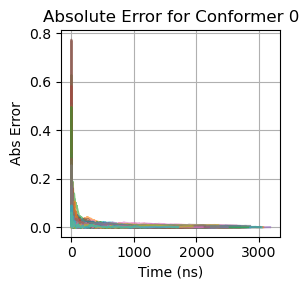

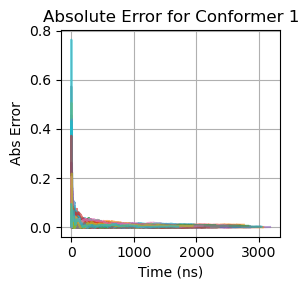

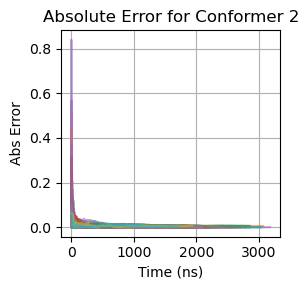

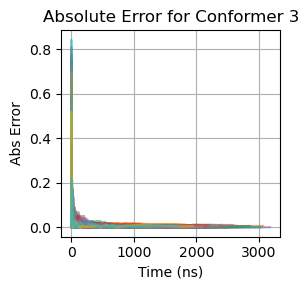

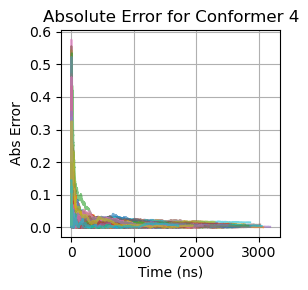

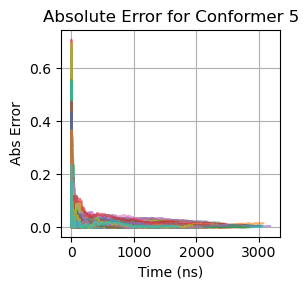

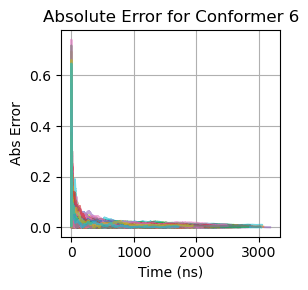

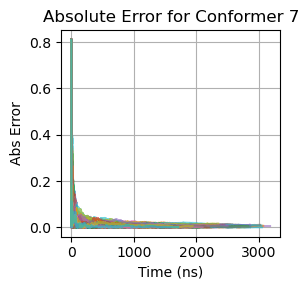

In [24]:
## Plot only state 0 

dt_in_ns = 0.01
ntraj = reshaped_all_comform.shape[0]
conform_num = 8
time_len = reshaped_all_comform[0][0].shape[1]
t = np.arange(time_len) * dt_in_ns  # Time axis in ns

for conform in range(conform_num):
    plt.figure(figsize=(3, 3))
    
    for i in range(ntraj):
        traj = reshaped_all_comform[i][0]  # shape (8, time)
        error = np.abs(traj[conform] - refer_array[0][conform])  # shape (time,)
        
        plt.plot(t, error, alpha=0.6, label=f'Traj {i}' if i < 10 else None)  # Limit labels

    plt.title(f'Absolute Error for Conformer {conform}')
    plt.xlabel('Time (ns)')
    plt.ylabel('Abs Error')
    plt.grid(True)
    if ntraj <= 10:
        plt.legend()
    plt.tight_layout()
    #plt.show()


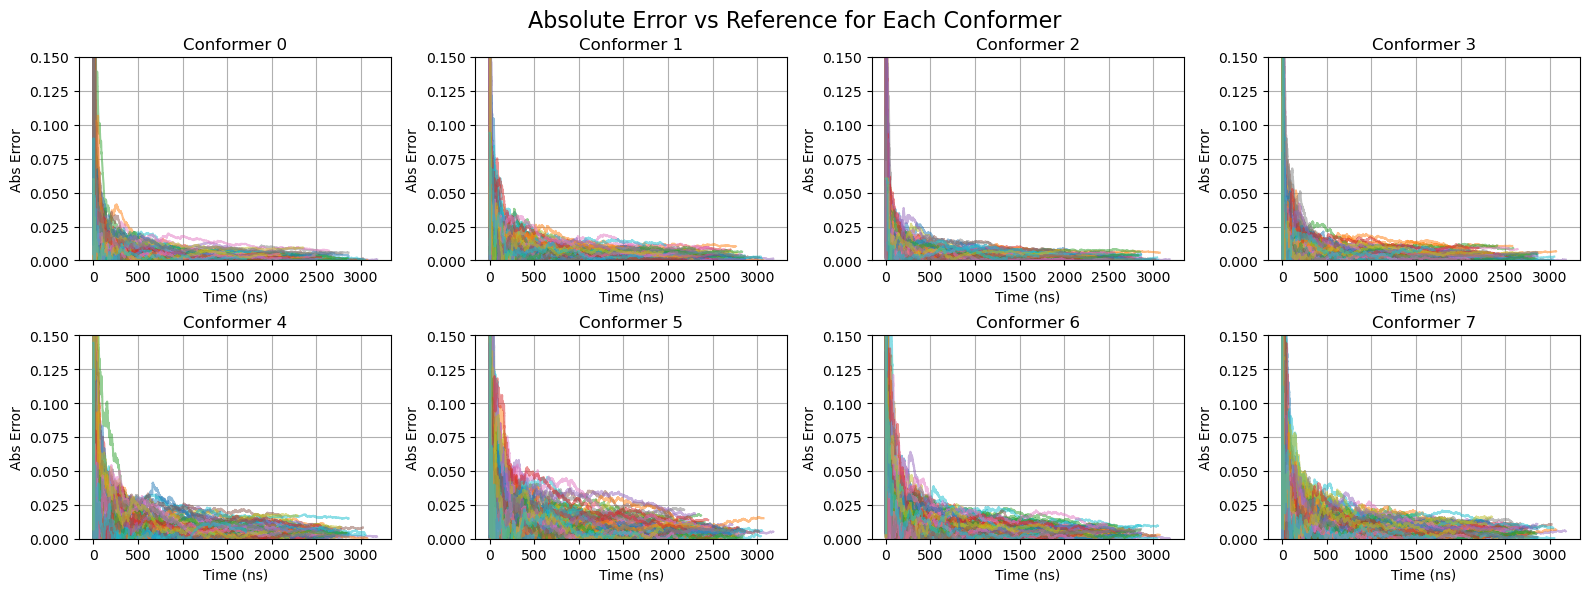

In [25]:
dt_in_ns = 0.01
ntraj = reshaped_all_comform.shape[0]
conform_num = 8
time_len = reshaped_all_comform[0][0].shape[1]
t = np.arange(time_len) * dt_in_ns  # Time axis in ns

# Set up 2x4 subplot grid
fig, axs = plt.subplots(2, 4, figsize=(16, 6))
axs = axs.flatten()  # Flatten for easy indexing

for conform in range(conform_num):
    ax = axs[conform]
    
    for i in range(ntraj):
        traj = reshaped_all_comform[i][0]  # shape (8, time)
        error = np.abs(traj[conform] - refer_array[0][conform])
        
        ax.plot(t, error, alpha=0.5)

    ax.set_title(f'Conformer {conform}')
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('Abs Error')
    ax.set_ylim(0, 0.15)
    ax.grid(True)

plt.tight_layout()
fig.suptitle('Absolute Error vs Reference for Each Conformer', fontsize=16)
plt.subplots_adjust(top=0.9)  # Make space for the title
plt.show()


## Calculate RMSD of the error

In [26]:

ntraj = reshaped_all_comform.shape[0]
conform_num = 8
time_len = reshaped_all_comform[0][0].shape[1]
t = np.arange(time_len) * dt_in_ns  # Time axis in ns

ref = refer_array[0].reshape(1, 8, 1)  # shape: (1, 8, 1)
data = reshaped_all_comform[:, 0, :, :]  # shape: (94, 8, 91002)  ## Calculate only state 0 

errors = np.abs(data - ref) ** 2  # result: (94, 8, 91002)
rmsd = np.sqrt(np.nansum(errors, axis=0) / errors.shape[0])

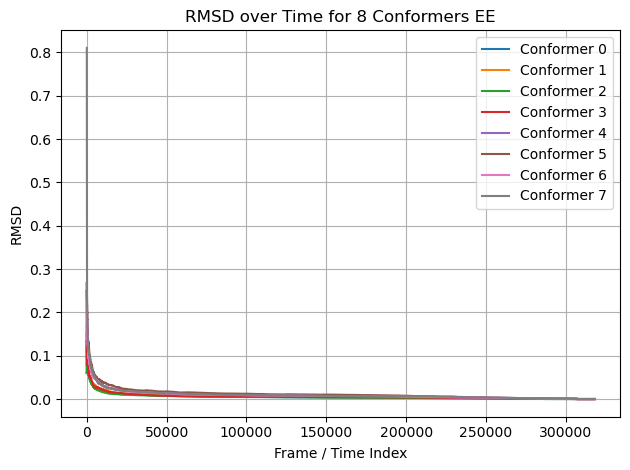

In [27]:
for i in range(8):
    plt.plot(rmsd[i], label=f'Conformer {i}')

plt.title("RMSD over Time for 8 Conformers EE")
plt.xlabel("Frame / Time Index")
plt.ylabel("RMSD")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [28]:
errors_result = [rmsd]

os.makedirs('population_data', exist_ok=True)

data_instance = Data(errors_result)
data_instance.save("population_data/error_8_conform.pkl")

In [29]:
rmsd.shape

(8, 318010)

In [33]:
errors_resul_reduced = [rmsd[:, ::100]]

os.makedirs('population_data', exist_ok=True)

data_instance = Data(errors_resul_reduced)
data_instance.save("population_data/error_8_conform_reduced.pkl")

## Population over time against stationary distribution population

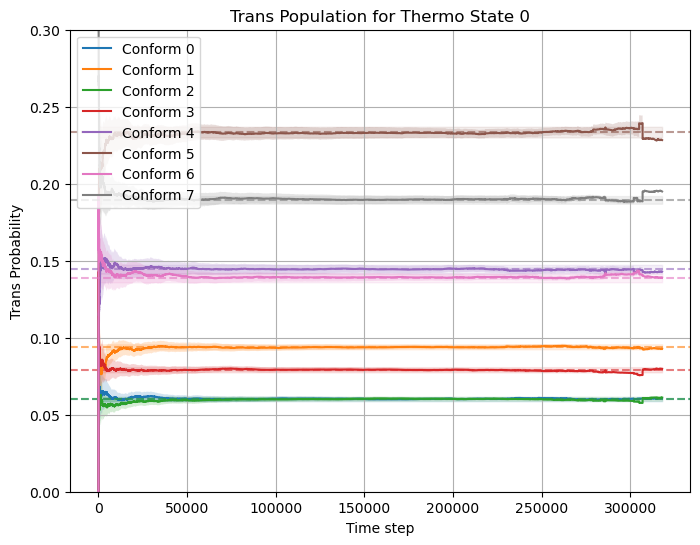

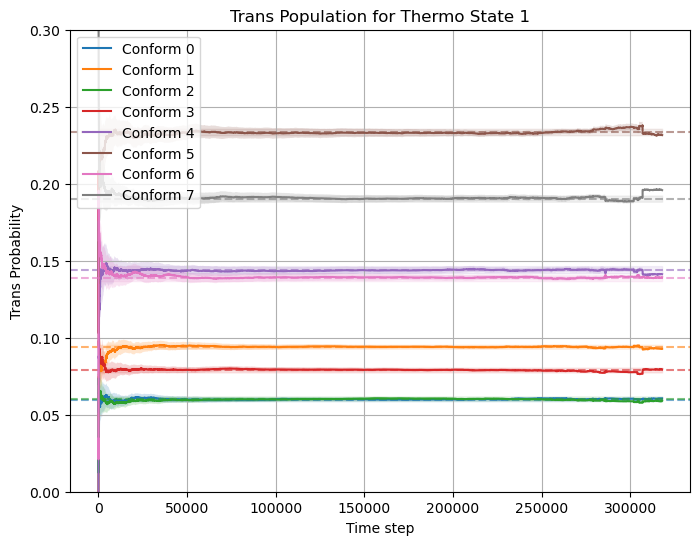

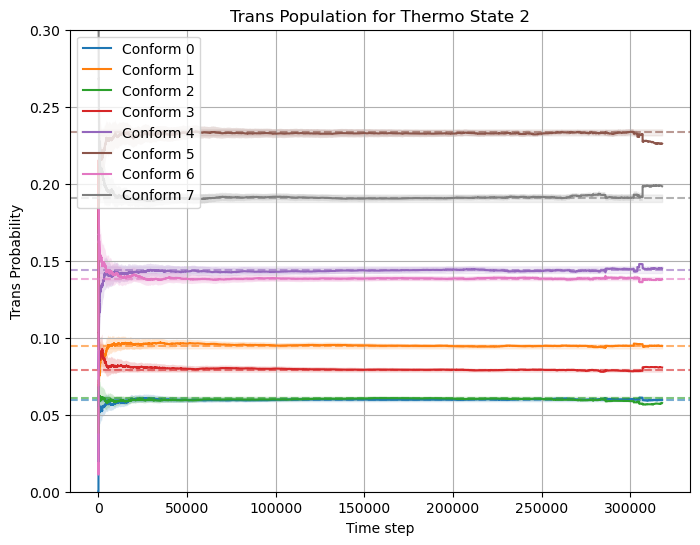

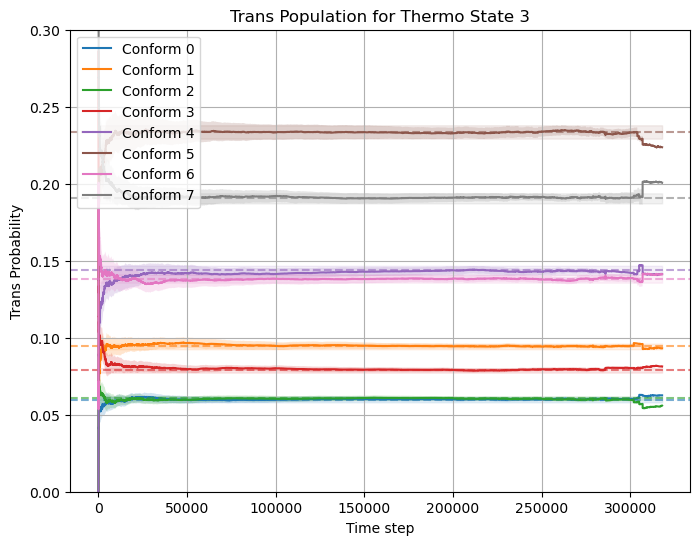

In [31]:
thermo_num = 4
conform_num = 8

for thermo in range(thermo_num):  # Loop over 6 thermodynamic states
    plt.figure(figsize=(8, 6))
    
    for conform in range(conform_num):  # Loop over 8 conformational states
        y = reshaped_mean[thermo, conform, :]
        yerr = reshaped_std[thermo, conform, :]
        x = np.arange(len(y))  # or use actual time values

        plt.plot(x, y, label=f'Conform {conform}')
        plt.fill_between(x, y - yerr, y + yerr, alpha=0.2)

        # Reference horizontal line
        ref_y = refer_array[thermo, conform]
        ref_yerr = refer_err_array[thermo, conform]

        plt.axhline(y=ref_y, linestyle='--', color=f'C{conform}', alpha=0.6)
        plt.fill_between(x, ref_y - ref_yerr, ref_y + ref_yerr, color=f'C{conform}', alpha=0.1)

    plt.title(f'Trans Population for Thermo State {thermo}')
    plt.xlabel('Time step')
    plt.ylabel('Trans Probability')
    plt.grid(True)
    plt.legend(loc='best')
    #plt.tight_layout()
    plt.ylim(0, 0.3)
    plt.show()


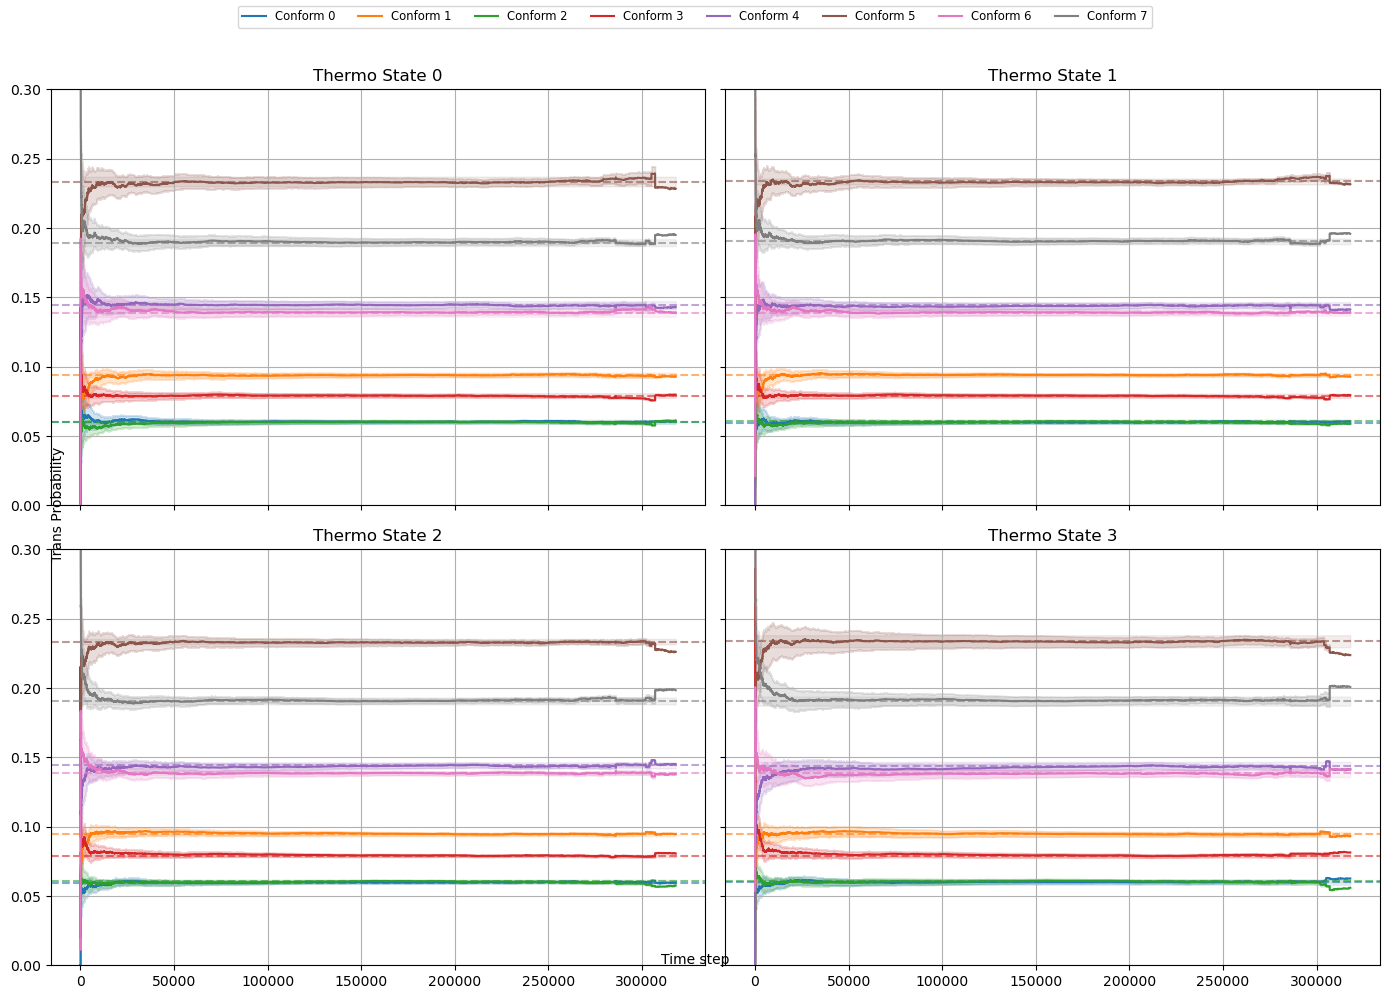

In [32]:
thermo_num = 4
conform_num = 8

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)

x = np.arange(reshaped_mean.shape[2])  # Or use actual time array

for thermo in range(thermo_num):
    row = thermo // 2
    col = thermo % 2
    ax = axes[row, col]

    for conform in range(conform_num):
        y = reshaped_mean[thermo, conform, :]
        yerr = reshaped_std[thermo, conform, :]

        # Plot main line
        line, = ax.plot(x, y, label=f'Conform {conform}')
        ax.fill_between(x, y - yerr, y + yerr, alpha=0.2, color=line.get_color())

        # Reference line and shaded error
        ref_y = refer_array[thermo, conform]
        ref_yerr = refer_err_array[thermo, conform]
        ax.axhline(y=ref_y, linestyle='--', color=line.get_color(), alpha=0.6)
        ax.fill_between(x, ref_y - ref_yerr, ref_y + ref_yerr, color=line.get_color(), alpha=0.1)

    ax.set_title(f'Thermo State {thermo}')
    ax.set_ylim(0, 0.3)
    ax.grid(True)

# Shared axis labels
fig.text(0.5, 0.04, 'Time step', ha='center')
fig.text(0.04, 0.5, 'Trans Probability', va='center', rotation='vertical')

# Shared legend (from last subplot)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=8, fontsize='small')

fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
